In [121]:
import os
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
# Diretório das imagens
data_dir = '/content/drive/MyDrive/TrabalhoIA/Imagens'

In [124]:
# Configurando o dispositivo (CPU ou GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando o dispositivo:", device)

Usando o dispositivo: cuda


In [125]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Converte para 3 canais (RGB)
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalização para 3 canais (RGB)
])

In [126]:
# Função de carregamento que aplica a rotação com base nos metadados EXIF
def load_image_with_rotation(path):
    image = Image.open(path)
    return ImageOps.exif_transpose(image)  # Aplica a rotação baseada nos metadados EXIF

In [127]:
# Dataset completo com transformações de treinamento
# full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
full_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=transform,
    loader=load_image_with_rotation  # Usa o loader personalizado para rotação correta
)
print("Classes:", full_dataset.classes)

Classes: ['A', 'B']


# Vizualiza dados transformados

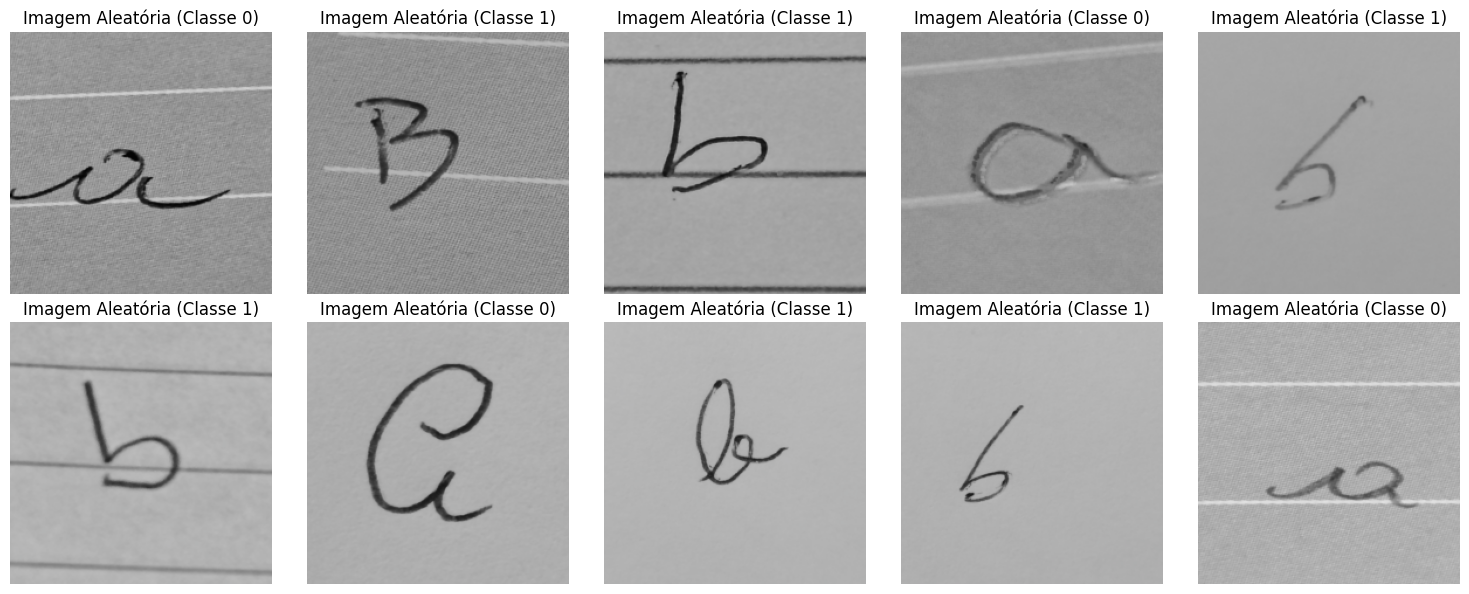

In [130]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms as transforms
from torchvision import datasets

# Função para desfazer a normalização e converter o tensor para uma imagem exibível
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.numpy().transpose((1, 2, 0))
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

# Seleciona 10 índices aleatórios do dataset
random_indices = random.sample(range(len(full_dataset)), 10)

# Exibe as 10 imagens aleatórias
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 linhas e 5 colunas
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    image, label = full_dataset[idx]
    image_np = denormalize(image)

    axes[i].imshow(image_np)
    axes[i].set_title(f"Imagem Aleatória (Classe {label})")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


# Divisão do dataset e criação de dataloader

In [131]:
# Tamanhos dos conjuntos
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size


In [132]:
# Divisão do dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


In [133]:
# Define o tamanho do lote
batch_size = 32

# Cria o DataLoader para o conjunto de treinamento, validação e teste
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Treinamento

In [145]:
import torch
import numpy as np

import torch

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100, patience=10, device='cpu'):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Treinamento
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Loss de Treino: {epoch_loss:.4f} Acc de Treino: {epoch_acc:.4f}")

        # Validação
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)

        print(f"Loss de Validação: {val_loss:.4f} Acc de Validação: {val_acc:.4f}\n")

        # Checa e salva o melhor modelo com base na perda de validação
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            print("Melhor modelo encontrado! Salvando...")
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1

        # Early Stopping
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return model


In [146]:
# Carrega o modelo EfficientNet_B2 pré-treinado
efficientnet_model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 2)
efficientnet_model = efficientnet_model.to(device)

In [147]:
# Carrega o modelo RegNet_X_800MF pré-treinado
regnet_model = models.regnet_x_800mf(weights=models.RegNet_X_800MF_Weights.IMAGENET1K_V2)
regnet_model.fc = nn.Linear(regnet_model.fc.in_features, 2)
regnet_model = regnet_model.to(device)

In [148]:
# Definição do critério de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=0.001)
optimizer_regnet = optim.Adam(regnet_model.parameters(), lr=0.001)

In [149]:
# Treinamento dos modelos
print("Treinando o EfficientNet_B2...")
efficientnet_model = train_model(efficientnet_model, criterion, optimizer_efficientnet, train_loader, val_loader, num_epochs=10, patience=2, device=device)


Treinando o EfficientNet_B2...
Epoch 1/10
----------
Loss de Treino: 0.3463 Acc de Treino: 0.8395
Loss de Validação: 0.4394 Acc de Validação: 0.8438

Melhor modelo encontrado! Salvando...
Epoch 2/10
----------
Loss de Treino: 0.1260 Acc de Treino: 0.9599
Loss de Validação: 0.1538 Acc de Validação: 0.9375

Melhor modelo encontrado! Salvando...
Epoch 3/10
----------
Loss de Treino: 0.0310 Acc de Treino: 0.9900
Loss de Validação: 0.1107 Acc de Validação: 0.9531

Melhor modelo encontrado! Salvando...
Epoch 4/10
----------
Loss de Treino: 0.0659 Acc de Treino: 0.9833
Loss de Validação: 0.1858 Acc de Validação: 0.9219

Epoch 5/10
----------
Loss de Treino: 0.0372 Acc de Treino: 0.9900
Loss de Validação: 0.0757 Acc de Validação: 0.9688

Melhor modelo encontrado! Salvando...
Epoch 6/10
----------
Loss de Treino: 0.0240 Acc de Treino: 0.9900
Loss de Validação: 0.0567 Acc de Validação: 0.9844

Melhor modelo encontrado! Salvando...
Epoch 7/10
----------
Loss de Treino: 0.0171 Acc de Treino: 0.993

In [150]:
print("Treinando o RegNet_X_800MF...")
regnet_model = train_model(regnet_model, criterion, optimizer_regnet, train_loader, val_loader, num_epochs=10, patience=2, device=device)


Treinando o RegNet_X_800MF...
Epoch 1/10
----------
Loss de Treino: 0.3318 Acc de Treino: 0.8462
Loss de Validação: 0.1196 Acc de Validação: 0.9531

Melhor modelo encontrado! Salvando...
Epoch 2/10
----------
Loss de Treino: 0.0853 Acc de Treino: 0.9632
Loss de Validação: 0.3634 Acc de Validação: 0.9375

Epoch 3/10
----------
Loss de Treino: 0.1089 Acc de Treino: 0.9732
Loss de Validação: 0.9669 Acc de Validação: 0.7031

Early stopping at epoch 3


# Classification Report

In [151]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [152]:
# Função de avaliação
def evaluate_model(model, model_name):
    model.eval()
    lres = []
    ytrue = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            pred = model(data)
            res = pred.argmax(dim=1).cpu().tolist()
            lres.extend(res)
            ytrue.extend(target.cpu().tolist())

    confusion = confusion_matrix(ytrue, lres)
    accuracy = accuracy_score(ytrue, lres)
    precision = precision_score(ytrue, lres, average='weighted')
    recall = recall_score(ytrue, lres, average='weighted')
    f1 = f1_score(ytrue, lres, average='weighted')

    print(f"\nResultados para o modelo: {model_name}")
    print("Matriz de Confusão:")
    print(confusion)
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Revocação (Recall): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nRelatório de Classificação:")
    print(classification_report(ytrue, lres, target_names=full_dataset.classes))


In [153]:
# Avaliando os modelos
evaluate_model(efficientnet_model, "EfficientNet_B2")




Resultados para o modelo: EfficientNet_B2
Matriz de Confusão:
[[35  0]
 [ 3 27]]
Acurácia: 0.9538
Precisão: 0.9575
Revocação (Recall): 0.9538
F1-Score: 0.9536

Relatório de Classificação:
              precision    recall  f1-score   support

           A       0.92      1.00      0.96        35
           B       1.00      0.90      0.95        30

    accuracy                           0.95        65
   macro avg       0.96      0.95      0.95        65
weighted avg       0.96      0.95      0.95        65



In [154]:
evaluate_model(regnet_model, "RegNet_X_800MF")


Resultados para o modelo: RegNet_X_800MF
Matriz de Confusão:
[[14 21]
 [ 0 30]]
Acurácia: 0.6769
Precisão: 0.8100
Revocação (Recall): 0.6769
F1-Score: 0.6496

Relatório de Classificação:
              precision    recall  f1-score   support

           A       1.00      0.40      0.57        35
           B       0.59      1.00      0.74        30

    accuracy                           0.68        65
   macro avg       0.79      0.70      0.66        65
weighted avg       0.81      0.68      0.65        65



# Armazenamento dos Modelos



In [155]:
# Salvando os modelos treinados
model_dir = '/content/drive/MyDrive/TrabalhoIA/Modelos'
os.makedirs(model_dir, exist_ok=True)

# Armazena o EfficientNet_B2
efficientnet_model_path = os.path.join(model_dir, 'efficientnet_b2.pth')
torch.save(efficientnet_model.state_dict(), efficientnet_model_path)

# Armazena o RegNet_X_800MF
regnet_model_path = os.path.join(model_dir, 'regnet_x_800mf.pth')
torch.save(regnet_model.state_dict(), regnet_model_path)


# Visualização de imagens e testes

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import torchvision.transforms as transforms
import torch

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
# Caminho da imagem para teste
image_path = '/content/drive/MyDrive/TrabalhoIA/Teste-Visualizacao/imgA.jpg'

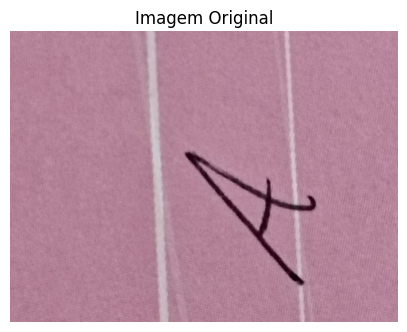

In [68]:
# Carrega a imagem original
original_image = Image.open(image_path)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(original_image)
ax.set_title("Imagem Original")
ax.axis("off")
plt.show()


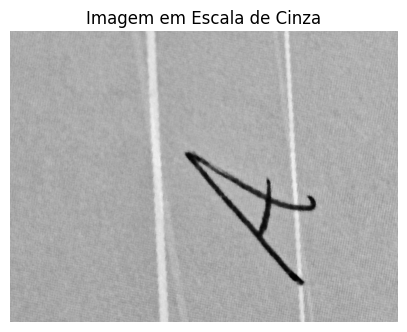

In [69]:
# 1. Converte para escala de cinza
gray_image = original_image.convert("L")
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(gray_image, cmap="gray")
ax.set_title("Imagem em Escala de Cinza")
ax.axis("off")
plt.show()

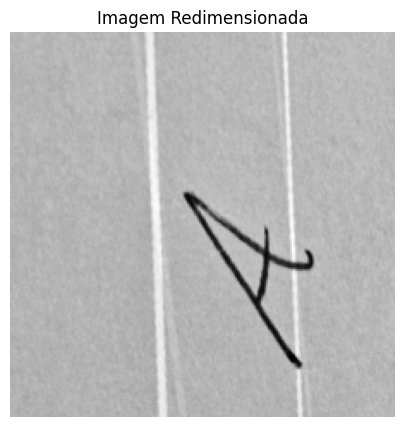

In [70]:
# 2. Redimensiona para 224x224
resized_image = gray_image.resize((224, 224))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(resized_image, cmap="gray")
ax.set_title("Imagem Redimensionada")
ax.axis("off")
plt.show()

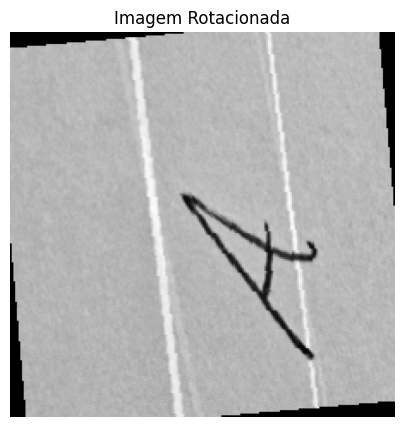

In [71]:
# 3. Aplica uma pequena rotação
rotated_image = resized_image.rotate(5)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(rotated_image, cmap="gray")
ax.set_title("Imagem Rotacionada")
ax.axis("off")
plt.show()

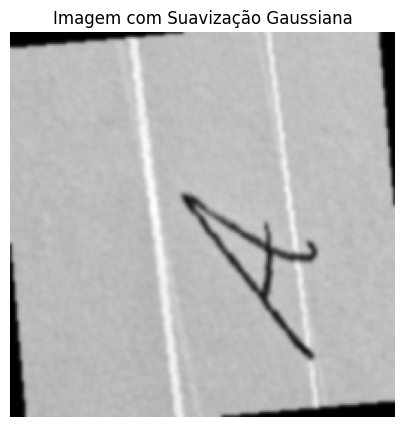

In [72]:
# 4. Aplica suavização com filtro Gaussiano
blurred_image = rotated_image.filter(ImageFilter.GaussianBlur(radius=1))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(blurred_image, cmap="gray")
ax.set_title("Imagem com Suavização Gaussiana")
ax.axis("off")
plt.show()

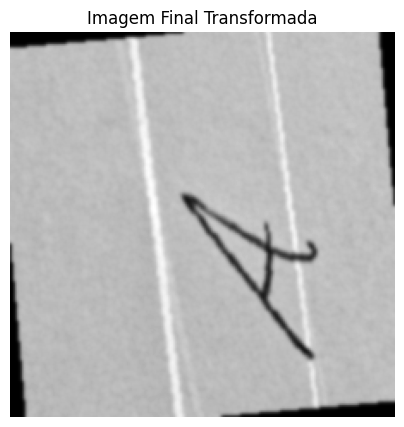

In [73]:
# 5. Converte para tensor e aplica normalização
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Para escala de cinza
])

tensor_image = transform(blurred_image).squeeze()

# Função para desfazer a normalização e exibir como imagem
def denormalize(tensor):
    mean = np.array([0.5])
    std = np.array([0.5])
    tensor = tensor.numpy()
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

# Exibe a imagem normalizada
normalized_image_np = denormalize(tensor_image)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(normalized_image_np, cmap="gray")
ax.set_title("Imagem Final Transformada")
ax.axis("off")
plt.show()
